## Better Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

class HopfieldEnergyNet(nn.Module):
    def __init__(self, num_neurons):
        super().__init__()
        self.num_neurons = num_neurons
        self.norm = nn.LayerNorm(num_neurons)
        self.weights = nn.Parameter(torch.zeros(num_neurons, num_neurons))
        self.bias = nn.Parameter(torch.zeros(num_neurons))
        nn.init.xavier_uniform_(self.weights)
        self.output_proj = nn.Linear(1, 1)  # Simple output projection for logits

    def energy(self, states):
        ## Batch matrix multiply to get interaction term
        interaction = torch.bmm(states.unsqueeze(1), torch.matmul(states, self.weights.transpose(-2, -1)).unsqueeze(2)).squeeze()
        ## matrix multiply to get bias term
        bias_term = torch.matmul(states, self.bias)
        ## return batch-averaged energy
        return -0.5 * interaction.mean() - bias_term.mean()

    def forward(self, input_neurons, input_values, output_neurons, steps=20, beta=1.0):
        batch_size = input_values.size(0)

        input_signal = torch.zeros(batch_size, self.num_neurons, device=self.weights.device)
        for i, neuron in enumerate(input_neurons):
            input_signal[:, neuron] = input_values[:, i]

        states = torch.zeros(batch_size, self.num_neurons, device=self.weights.device)

        for _ in range(steps):
            activation = torch.matmul(states, self.weights) + self.bias + input_signal
            new_states = torch.tanh(beta * activation)
            states = self.norm(states + new_states)
            states = states + 0.01 * torch.randn_like(states)

        outputs = self.output_proj(states[:, output_neurons].unsqueeze(-1)).squeeze(-1)
        return outputs, states

# Setup
num_neurons = 30
model = HopfieldEnergyNet(num_neurons)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Toy data
xor_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
xor_labels = torch.tensor([0., 1., 1., 0.], dtype=torch.float32)
and_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
and_labels = torch.tensor([0., 0., 0., 1.], dtype=torch.float32)
nand_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
nand_labels = torch.tensor([1., 1., 1., 0.], dtype=torch.float32)
not_inputs = torch.tensor([[-1.], [1.]], dtype=torch.float32)
not_labels = torch.tensor([1., 0.], dtype=torch.float32)

xor_in_neurons = [0, 1]
xor_out_neurons = [2]
and_in_neurons = [3, 4]
and_out_neurons = [5]
nand_in_neurons = [6, 7]
nand_out_neurons = [8]
not_in_neurons = [9]
not_out_neurons = [10]

# Training loop (joint for simplicity)
for epoch in range(4000):
    optimizer.zero_grad()
    ## Compute outputs and states for XOR
    xor_outputs, xor_states = model(xor_in_neurons, xor_inputs, xor_out_neurons)
    ## Compute loss for XOR
    xor_loss = F.binary_cross_entropy_with_logits(xor_outputs.squeeze(), xor_labels)
    ## Compute outputs and states for AND
    and_outputs, and_states = model(and_in_neurons, and_inputs, and_out_neurons)
    ## Compute loss for AND
    and_loss = F.binary_cross_entropy_with_logits(and_outputs.squeeze(), and_labels)
    ## Compute outputs and states for NAND
    nand_outputs, nand_states = model(nand_in_neurons, nand_inputs, nand_out_neurons)
    ## Compute loss for NAND
    nand_loss = F.binary_cross_entropy_with_logits(nand_outputs.squeeze(), nand_labels)
    ## Compute outputs and states for NOT
    not_outputs, not_states = model(not_in_neurons, not_inputs, not_out_neurons)
    ## Compute loss for NOT
    not_loss = F.binary_cross_entropy_with_logits(not_outputs.squeeze(), not_labels)
    ## Compute total task loss (XOR + AND + NAND + NOT)
    task_loss = xor_loss + and_loss + nand_loss + not_loss
    ## Compute sparsity loss
    sparsity_loss = 0.001 * (model.weights.abs().sum())
    ## Compute full loss
    full_loss = task_loss + sparsity_loss
    ## Backpropagate
    full_loss.backward()
    optimizer.step()
    if epoch % 800 == 0:
        print(f"Epoch {epoch}: XOR Loss {xor_loss.item():.4f}, AND Loss {and_loss.item():.4f}, NAND Loss {nand_loss.item():.4f}, NOT Loss {not_loss.item():.4f}")

# Inference
with torch.no_grad():
    xor_preds, _ = model(xor_in_neurons, xor_inputs, xor_out_neurons)
    and_preds, _ = model(and_in_neurons, and_inputs, and_out_neurons)
    nand_preds, _ = model(nand_in_neurons, nand_inputs, nand_out_neurons)
    not_preds, _ = model(not_in_neurons, not_inputs, not_out_neurons)
    print("XOR Preds:", torch.sigmoid(xor_preds.squeeze()))
    print("AND Preds:", torch.sigmoid(and_preds.squeeze()))
    print("NAND Preds:", torch.sigmoid(nand_preds.squeeze()))
    print("NOT Preds:", torch.sigmoid(not_preds.squeeze()))
# Visualization (using weight matrix instead of attn_probs)
def get_energy_graph(model, k):
    weight_matrix = model.weights.data.cpu().numpy()
    weight_matrix = (weight_matrix - weight_matrix.min()) / (weight_matrix.max() - weight_matrix.min() + 1e-8)
    G = nx.Graph() # Use your best k
    edges = []
    for i in range(model.num_neurons):
        for j in range(i + 1, model.num_neurons):
            edges.append((i, j, weight_matrix[i, j]))
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:k]
    
    for i in range(model.num_neurons):
        G.add_node(i)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)
    return G



Epoch 0: XOR Loss 0.7048, AND Loss 0.6864, NAND Loss 0.7360, NOT Loss 0.7484
Epoch 800: XOR Loss 0.0104, AND Loss 0.0153, NAND Loss 0.0095, NOT Loss 0.0113
Epoch 1600: XOR Loss 0.0027, AND Loss 0.0040, NAND Loss 0.0028, NOT Loss 0.0027
Epoch 2400: XOR Loss 0.0073, AND Loss 0.0099, NAND Loss 0.0072, NOT Loss 0.0030
Epoch 3200: XOR Loss 0.0011, AND Loss 0.0011, NAND Loss 0.0007, NOT Loss 0.0007
XOR Preds: tensor([3.3880e-04, 9.9946e-01, 9.9904e-01, 4.8595e-04])
AND Preds: tensor([6.2146e-04, 6.0441e-04, 6.4538e-04, 9.9910e-01])
NAND Preds: tensor([9.9966e-01, 9.9972e-01, 9.9966e-01, 5.9404e-04])
NOT Preds: tensor([9.9933e-01, 2.9259e-04])


k=40: Modularity=0.4587, Components=4
k=45: Modularity=0.4280, Components=4
k=50: Modularity=0.4122, Components=4
k=55: Modularity=0.3520, Components=4
k=60: Modularity=0.3565, Components=3
k=65: Modularity=0.3064, Components=2
k=70: Modularity=0.3070, Components=2
k=75: Modularity=0.2689, Components=2
k=80: Modularity=0.2697, Components=2
k=85: Modularity=0.2466, Components=1
k=90: Modularity=0.2259, Components=1
k=95: Modularity=0.2590, Components=1
k=100: Modularity=0.2285, Components=1
Best balanced k: 55 (modularity=0.4587)
Detected clusters: {3: 0, 4: 0, 7: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 19: 0, 27: 0, 28: 0, 1: 1, 5: 1, 6: 1, 8: 1, 9: 1, 17: 1, 18: 1, 20: 1, 21: 1, 25: 1, 29: 1, 0: 2, 2: 2, 22: 2, 24: 2, 15: 2, 16: 3, 23: 4, 26: 5}


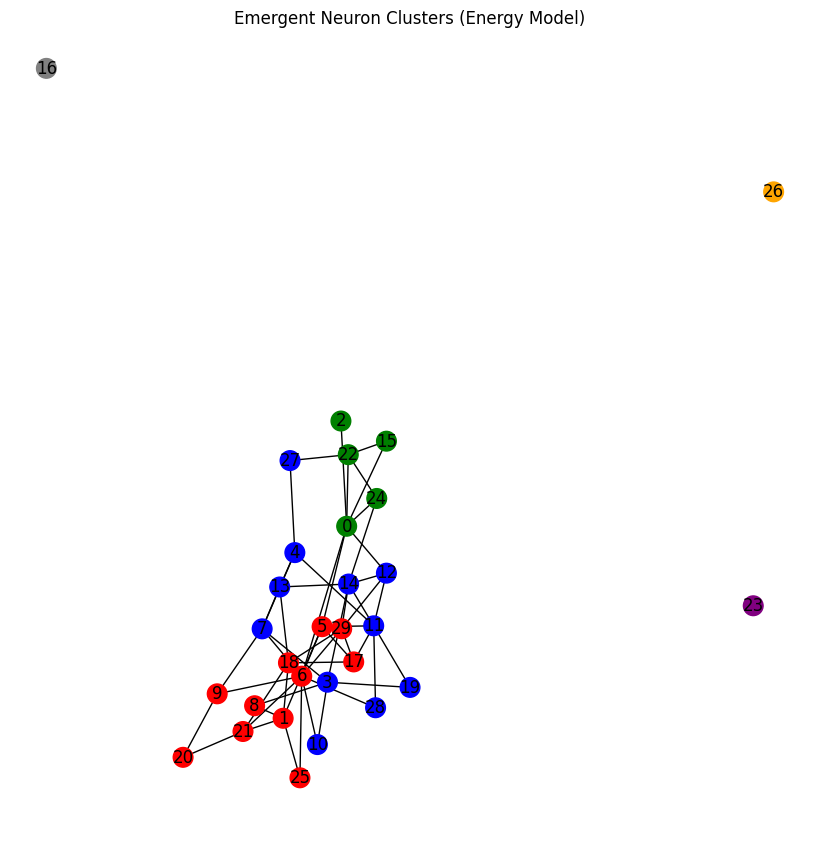

In [2]:
from networkx.algorithms.community import modularity
from kneed import KneeLocator

def find_best_k(model, input_neurons, input_values, output_neurons, min_k=10, max_k=100, step=5, max_components=4):
    k_values = []
    mod_values = []
    for k in range(min_k, max_k + 1, step):
        G = get_energy_graph(model, k=k)
        components = nx.number_connected_components(G)
        communities = greedy_modularity_communities(G, weight='weight')
        current_mod = modularity(G, communities, weight='weight')
        if components <= max_components:  # Filter for connectedness
            k_values.append(k)
            mod_values.append(current_mod)
            print(f"k={k}: Modularity={current_mod:.4f}, Components={components}")
    
    if not k_values:
        print("No valid k found; try increasing max_components")
        return min_k
    
    # Find elbow (knee) in modularity curve
    kneedle = KneeLocator(k_values, mod_values, curve="convex", direction="decreasing")
    best_k = kneedle.knee if kneedle.knee else k_values[np.argmax(mod_values)]
    print(f"Best balanced k: {best_k} (modularity={max(mod_values):.4f})")
    return best_k

best_k = find_best_k(model, xor_in_neurons, xor_inputs, xor_out_neurons)


G = get_energy_graph(model, k=best_k)
pos = nx.spring_layout(G, seed=42)
communities = greedy_modularity_communities(G, weight='weight')
partition = {}
for cluster_id, comm in enumerate(communities):
    for node in comm:
        partition[node] = cluster_id
print("Detected clusters:", partition)

plt.figure(figsize=(8, 8))
colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
node_colors = [colors.get(partition.get(i, 0), 'gray') for i in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=200, with_labels=True)
plt.title("Emergent Neuron Clusters (Energy Model)")
plt.show()

import plotly.graph_objects as go

def visualize_3d(G, pos, partition):
    # Generate 3D positions (use spring_layout with dim=3 or random)
    pos_3d = nx.spring_layout(G, dim=3, seed=42)

    # Edge traces
    edge_x, edge_y, edge_z = [], [], []
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]

    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(width=2, color='gray'), hoverinfo='none')

    # Node traces
    node_x, node_y, node_z = [], [], []
    node_colors = []
    colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
    for node in G.nodes():
        x, y, z = pos_3d[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_colors.append(colors.get(partition.get(node, 0), 'gray'))

    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers+text', marker=dict(size=10, color=node_colors, opacity=0.8),
                              text=list(G.nodes()), hoverinfo='text')

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title='3D Emergent Neuron Clusters', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z')))
    fig.show()


# Use the visualize_3d function from earlier for 3D
visualize_3d(G, pos, partition)